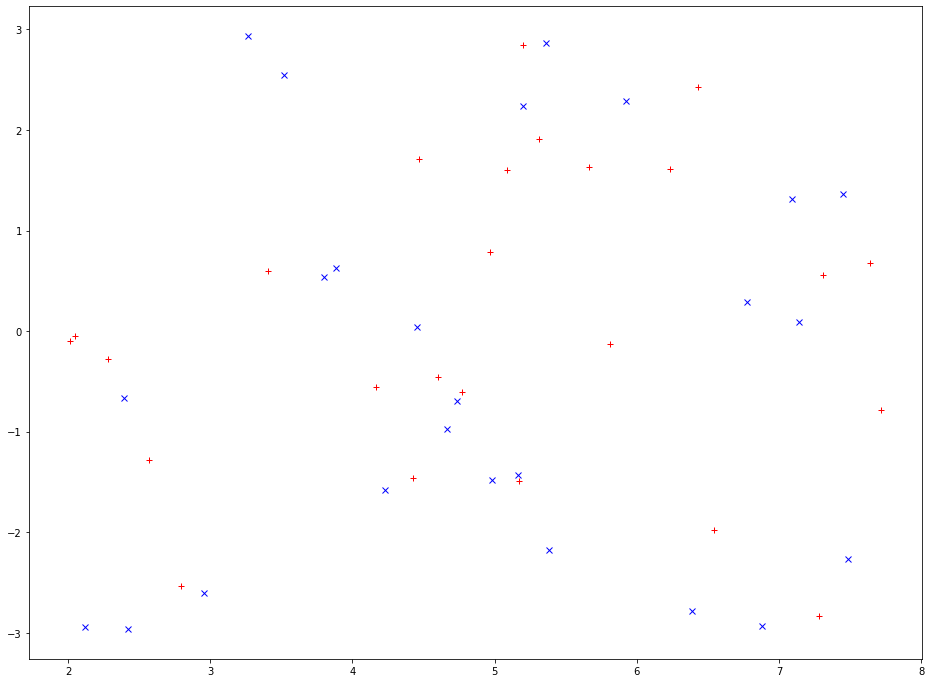

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

min_vals = np.array([2, -3])
max_vals = np.array([8, 3])
N = 50

points = (max_vals - min_vals)*np.random.random((N, 2)) + min_vals

s = int(0.5*N)
pos = points[:s]
neg = points[s:]

plt.figure(figsize=(16,12))
plt.plot(pos[:, 0], pos[:, 1], 'r+')
plt.plot(neg[:, 0], neg[:, 1], 'bx')
plt.show()

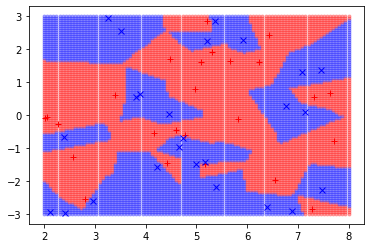

In [34]:
def nn(x, y, pos, neg):
    v = np.array([[x, y]])
    p = np.sum(np.power(pos - v, 2),axis=1)
    n = np.sum(np.power(neg - v, 2),axis=1)
    return np.min(p) < np.min(n)

for xs in np.linspace(min_vals[0], max_vals[0], 100):
    for ys in np.linspace(min_vals[1], max_vals[1], 100):
        if nn(xs, ys, pos, neg):
            plt.plot(xs,ys, 'r.', alpha=0.3)
        else:
            plt.plot(xs,ys, 'b.', alpha=0.3)

plt.plot(pos[:, 0], pos[:, 1], 'r+')
plt.plot(neg[:, 0], neg[:, 1], 'bx')
plt.show()

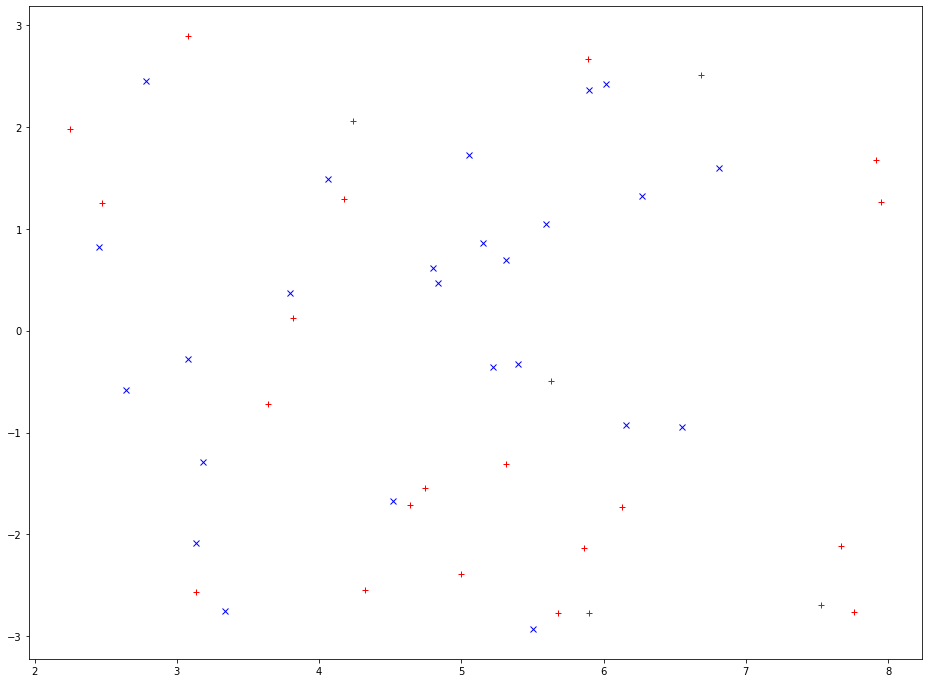

In [38]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

min_vals = np.array([2, -3])
max_vals = np.array([8, 3])
N = 50

points = (max_vals - min_vals)*np.random.random((N, 2)) + min_vals

s = int(0.5*N)
pos = points[:s]
neg = points[s:]

plt.figure(figsize=(16,12))
plt.plot(pos[:, 0], pos[:, 1], 'r+')
plt.plot(neg[:, 0], neg[:, 1], 'bx')
plt.show()

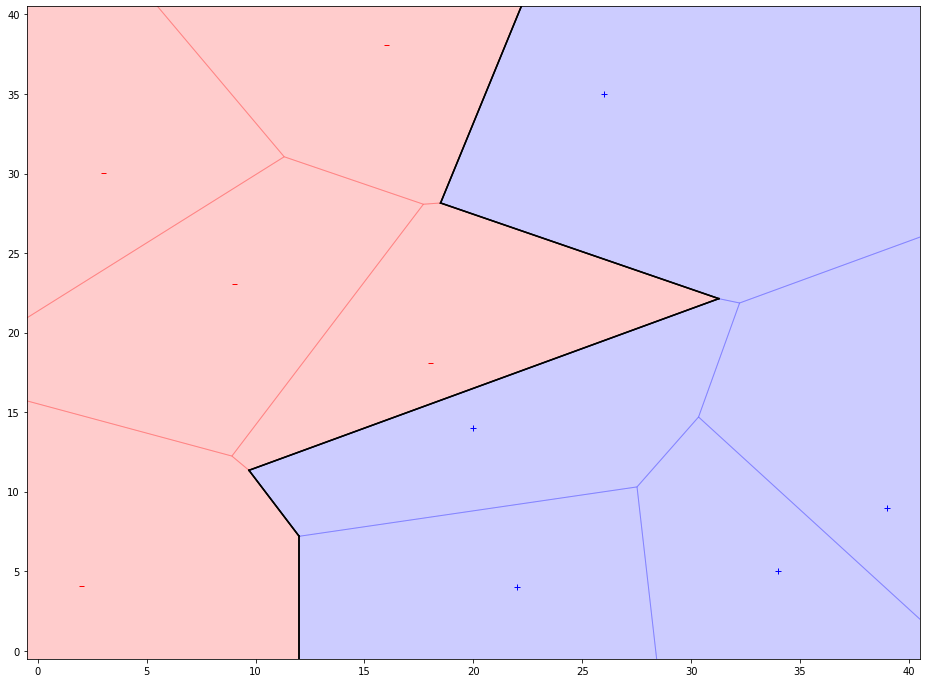

In [36]:
%matplotlib inline

import math
from scipy.spatial import Voronoi, voronoi_plot_2d

import matplotlib.pyplot as plt
import numpy as np

# min_vals = np.array([2, -3])
# max_vals = np.array([8, 3])
# N = 100
# s = int(0.5*N)

# points = ([5, 5])*np.random.random((s, 2)) + min_vals
# points = np.concatenate((points, ([5, 5]) *np.random.random((s, 2)) + min_vals + [1, 1]))

# pos = points[:s]
# neg = points[s:]


def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def nn(x, y, pos, neg):
    v = np.array([[x, y]])
    p = np.sum(np.power(pos - v, 2), axis=1)
    n = np.sum(np.power(neg - v, 2), axis=1)
    return np.min(p) < np.min(n)

def plot_voronoi(points, min_vals, max_vals, off=0.5):
    """
    Plots the given points as a voronoi diagram using min_vals and max_vals
    as boundaries for the plot.
    """

    # transform to a list of positive and negative values
    pos = np.array([key for key, val in points.items() if val == 1])
    neg = np.array([key for key, val in points.items() if val == -1])

    # transform to a simple list
    points = np.array(list(points.keys()))

    fig = plt.figure(figsize=(16,12))
    axis = fig.add_subplot()

    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)

    # fill polygons with colour
    for region in regions:
        polygon = vertices[region]
        cent = polygon.mean(axis=0)
        color = 'b' if  nn(cent[0], cent[1], pos, neg) else 'r'
        axis.fill(*zip(*polygon), color=color, alpha=0.2)

    # 
    axis.plot(pos[:, 0], pos[:, 1], 'b+')
    axis.plot(neg[:, 0], neg[:, 1], 'r+', marker=r'$-$')

    for region in regions:
        polygon = vertices[region]
        for i in range(polygon.shape[0]):
            p1 = polygon[i, :]
            p2 = polygon[(i + 1) % polygon.shape[0], :]
            v = p2 - p1
            v = v / np.linalg.norm(v)
            r = np.array([[math.cos(math.pi/2), -math.sin(math.pi/2)],
                        [math.sin(math.pi/2), math.cos(math.pi/2)]])
            v = np.dot(r, v)
            cent = (p1 + p2) / 2
            
            dv1 = cent + 0.01*v
            dv2 = cent - 0.01*v
            if nn(dv1[0], dv1[1], pos, neg) != nn(dv2[0], dv2[1], pos, neg):
                axis.plot([p1[0], p2[0]], [p1[1], p2[1]], 'black')

    plt.xlim(min_vals[0]-off, max_vals[0]+off)
    plt.ylim(min_vals[1]-off, max_vals[1]+off)
    plt.show()

points = {(20, 14): 1, (9, 23): -1, (2, 4): -1, (39, 9): 1, (34, 5): 1, (18, 18): -1, (22, 4): 1, (3, 30):-1, (26, 35):1, (16, 38):-1}

plot_voronoi(points, np.array([0, 0]), np.array([40, 40]))

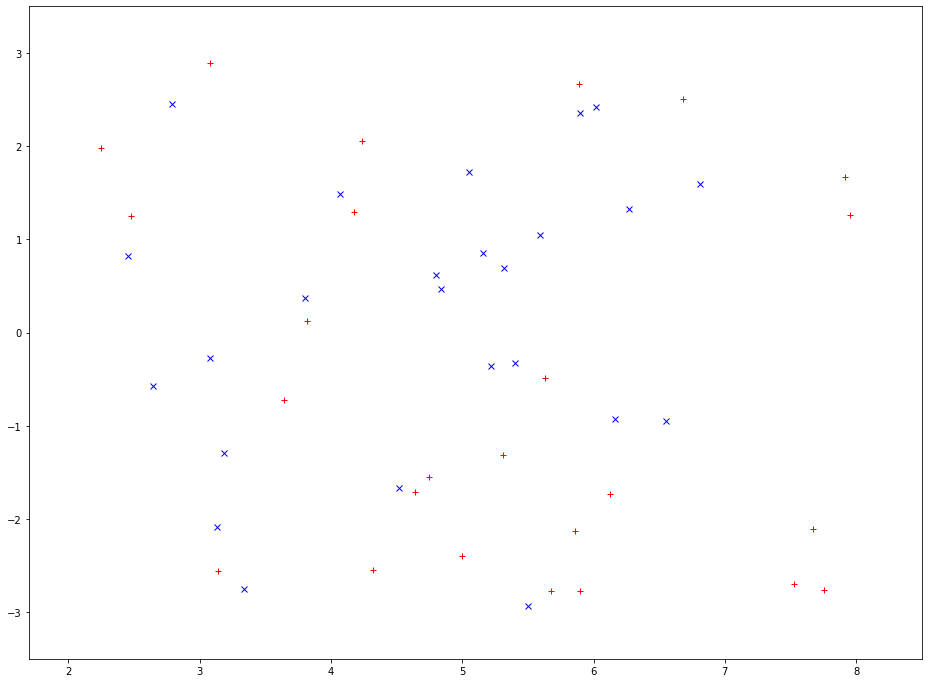

In [70]:
plt.figure(figsize=(16,12))
off = 0.5 
plt.xlim(min_vals[0]-0.3, max_vals[0]+off)
plt.ylim(min_vals[1]-off, max_vals[1]+off)
plt.plot(pos[:, 0], pos[:, 1], 'r+')
plt.plot(neg[:, 0], neg[:, 1], 'bx')
plt.show()